### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [3]:
# 確保使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
print(tf.__version__)

1.14.0


In [4]:
# pip install --user keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

In [5]:
# 下載基於 keras 的 yolov3 程式碼
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd keras-yolo3

/home/andy/kaggle_facemask/keras-yolo3


In [6]:
import os
if not os.path.exists("model_data/yolo.h5"):
    # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
    print("Model doesn't exist, downloading...")
    os.system("wget https://pjreddie.com/media/files/yolov3.weights")
    print("Converting yolov3.weights to yolo.h5...")
    os.system("python3 convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
    print("Model exist")

Model exist


In [7]:
from glob import glob
imgs_path = glob("/data/NFS/andy_data/yolo/kaggle_facemask/images/*.png")
imgs_path.sort()
num = int(len(imgs_path)*0.1)

f = open("/data/NFS/andy_data/yolo/kaggle_facemask/train.txt", "w")
for i in range(num*9):
    name = imgs_path[i][48:-4]
    f.write(name + "\n")
f.close()

f = open("/data/NFS/andy_data/yolo/kaggle_facemask/val.txt", "w")
for i in range(num*9, len(imgs_path)):
    name = imgs_path[i][48:-4]
    f.write(name + "\n")
f.close()

In [6]:
# if not os.path.exists("train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
from os import getcwd

sets=['train', 'val']

# Facemask 的資料類別
classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

# 把 annotation 轉換訓練時需要的資料形態
def convert_annotation(image_id, list_file):
    in_file = open('/data/NFS/andy_data/yolo/kaggle_facemask/annotations/%s.xml'%(image_id))
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

for image_set in sets:
    image_ids = open('/data/NFS/andy_data/yolo/kaggle_facemask/%s.txt'%(image_set)).read().strip().split()
    annotation_path = '%s.txt'%(image_set)
    list_file = open(annotation_path, 'w')
    print("save annotation at %s" % annotation_path)
    for image_id in image_ids:
        list_file.write('/data/NFS/andy_data/yolo/kaggle_facemask/images/%s.png'%(image_id))
        convert_annotation(image_id, list_file)
        list_file.write('\n')
    list_file.close()

save annotation at train.txt
save annotation at val.txt


In [8]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


In [9]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [9]:
if not os.path.exists("model_data/yolo_weights.h5"):
    print("Converting pretrained YOLOv3 weights for training")
    os.system("python3 convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Pretrained weights exists


In [10]:
import warnings
warnings.filterwarnings("ignore")

annotation_path = 'train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 64
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    history1 = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 4 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    history2 = model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')








Create YOLOv3 model with 9 anchors and 3 classes.
Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 689 samples, val on 76 samples, with batch size 64.


Epoch 1/50
10/10 [==============================] - 53s 5s/step - loss: 5130.2267 - val_loss: 2613.4045
Epoch 2/50
10/10 [==============================] - 47s 5s/step - loss: 1567.6315 - val_loss: 933.2173
Epoch 3/50
10/10 [==============================] - 47s 5s/step - loss: 673.8043 - val_loss: 462.7853
Epoch 4/50
10/10 [==============================] - 26s 3s/step - loss: 394.7889 - val_loss: 325.0429
Epoch 5/50
10/10 [==============================] - 46s 5s/step - loss: 282.6140 - val_loss: 253.0758
Epoch 6/50
10/10 [==============================] - 46s 5s/step - loss: 230.7269 - val_loss: 204.3666
Epoch 7/50
10/10 [==============================] - 45s 5s/step - loss: 201.0089

172/172 [==============================] - 52s 300ms/step - loss: 27.5988 - val_loss: 28.7940
Epoch 56/100
172/172 [==============================] - 50s 294ms/step - loss: 26.9375 - val_loss: 26.1576
Epoch 57/100
172/172 [==============================] - 50s 291ms/step - loss: 25.6397 - val_loss: 27.6022
Epoch 58/100
172/172 [==============================] - 52s 302ms/step - loss: 26.1494 - val_loss: 28.6716
Epoch 59/100
172/172 [==============================] - 52s 303ms/step - loss: 25.6083 - val_loss: 27.2874

Epoch 00059: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 60/100
172/172 [==============================] - 51s 298ms/step - loss: 25.0568 - val_loss: 26.3321
Epoch 61/100
172/172 [==============================] - 52s 300ms/step - loss: 24.5089 - val_loss: 26.1953
Epoch 62/100
172/172 [==============================] - 51s 298ms/step - loss: 24.1559 - val_loss: 26.4557

Epoch 00062: ReduceLROnPlateau reducing learning rate to 9.999999747378752e

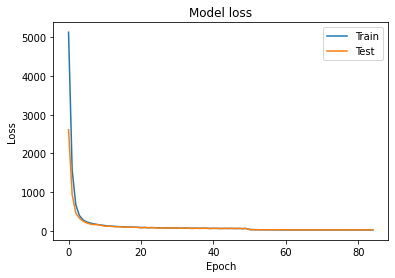

In [26]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'] + history2.history['loss'])
plt.plot(history1.history['val_loss'] + history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [12]:
annotation_path = 'train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)








logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(416, 416, 3)
Found 4 boxes for img
without_mask 0.67 (247, 87) (283, 123)
without_mask 0.94 (63, 155) (112, 196)
with_mask 0.89 (103, 94) (138, 134)
with_mask 0.96 (297, 151) (329, 195)
2.631240952759981


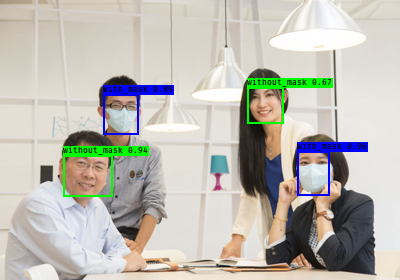

In [12]:
from PIL import Image
image = Image.open("/data/NFS/andy_data/yolo/kaggle_facemask/images/maksssksksss96.png")
r_image = yolo_model.detect_image(image)
r_image

In [15]:
from yolo import detect_video